In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [2]:
from pauli_mani import PauliPoly

In [3]:
## Arbitary Hamiltonian
qubits = 4
n_dim = int(2**qubits)
h_r = np.matrix(np.random.random((n_dim, n_dim)))
h_c = np.matrix(np.random.random((n_dim, n_dim)))
A_h = h_r + 1j*h_c
H = A_h.H@A_h

In [4]:
# Get eigen terms
evals, evectors = np.linalg.eig(H)
evals.real

array([1.32376525e+02, 9.19763127e+00, 5.65966579e+00, 5.21804728e+00,
       4.61466349e+00, 3.53006786e+00, 2.87550002e+00, 2.12777497e+00,
       1.58532724e+00, 1.23466214e+00, 6.04837060e-03, 7.55430267e-01,
       5.71442422e-01, 1.03026539e-01, 2.38168433e-01, 3.56414179e-01])

In [5]:
# Test the normality
for i in range(0, n_dim):
    print(np.linalg.norm(evectors[i]))

0.999999999999999
0.9999999999999997
1.0000000000000004
1.0000000000000004
0.9999999999999991
0.9999999999999994
0.9999999999999997
1.0000000000000016
1.0000000000000002
1.000000000000001
1.000000000000001
0.9999999999999987
0.9999999999999998
0.9999999999999996
0.999999999999999
1.000000000000001


In [6]:
# Orthogonal
evectors[0]@(evectors[1].H)

matrix([[2.77555756e-16+3.05311332e-16j]])

In [7]:
spectrum = [(e,ev)for e, ev in zip(evals.real, evectors)]

In [8]:
spectrum.sort()

In [9]:
# Spectrums
for e, v in spectrum:
    print(e)

0.00604837060320899
0.1030265388203518
0.23816843318109118
0.35641417872966624
0.5714424217733866
0.755430266995803
1.23466214430503
1.5853272392453848
2.1277749664132544
2.875500019514425
3.530067856513459
4.614663490932679
5.218047279757027
5.659665790544063
9.197631268798107
132.37652534104325


## Decompose the given Hamiltonian

In [10]:
from copy import deepcopy

In [11]:
H_test = deepcopy(H)

In [12]:
ppoly = PauliPoly.from_matrix(H_test)
H_poly = ppoly.to_matrix()
mixed_state = deepcopy(H_poly.sum(axis=1))
m_amp = np.sqrt((mixed_state.conj()*mixed_state).sum())
mixed_state /= m_amp

In [13]:
np.linalg.norm(mixed_state)

1.0

In [14]:
mixed_state

array([0.26472101+0.03214333j, 0.23209201-0.01130189j,
       0.22635612-0.02025818j, 0.27617283-0.00311788j,
       0.18909797-0.02379891j, 0.27301192+0.04094024j,
       0.2217382 +0.0290714j , 0.2743087 +0.02598324j,
       0.23930658-0.02738535j, 0.24473742-0.01190226j,
       0.2848397 -0.03834552j, 0.22609125-0.01833547j,
       0.23286471-0.00412221j, 0.25990888+0.03029694j,
       0.26048474-0.01709405j, 0.25540011+0.01722657j])

## Implement Spectrum Search Algorithm

In [15]:
## Quantum Circuit
import qiskit
from qiskit.circuit.library import StatePreparation
from qiskit.quantum_info import Statevector
from qiskit import QuantumCircuit
from qiskit_algorithms import 

In [ ]:
def get_resources(mix_state, known_states):
        n = mix_state.size
        # sum known_state
        # nomarlization

        M0 = 
        Hw = np.identity(n) - 
        H0 = np.identity(n)
        return Hw, H0, M0

In [16]:
q_mix_state_vec = Statevector(mixed_state)

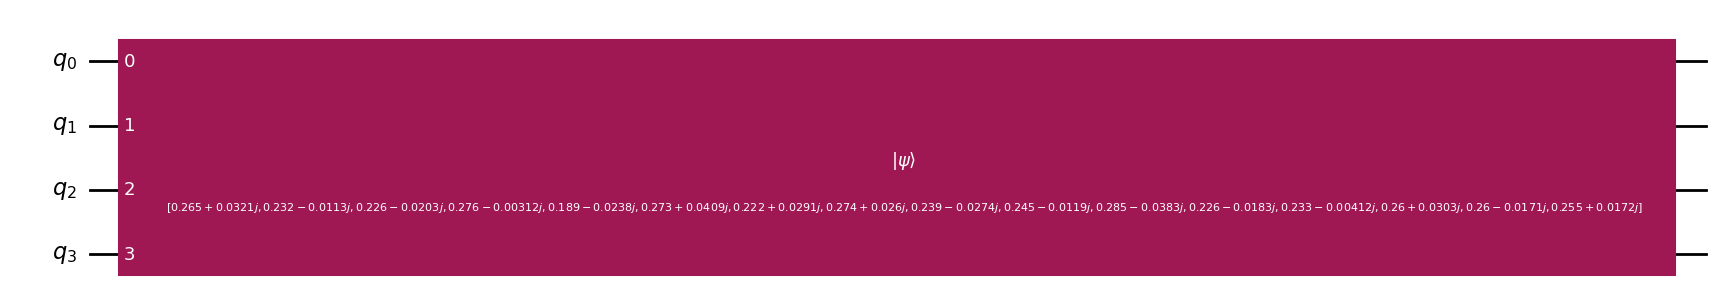

In [18]:
# Initial preparation
# 
circ = QuantumCircuit(qubits)
circ.initialize(q_mix_state_vec, circ.qubits) # initialize the mixed state
circ.draw('mpl')

## Current Stage(ITE): 

1. Qiskit Only provides Variational Quantum Imaginary Time evolution routine
2. The routine needs Ansatz to work on.
3. Qiskit provides convenience routines to work on the Ansatz, however, the proper choice is still remained.
4. Implement the ITE routine is required to work on the routine.

## Current Stage(Custom Grover Algorithm)